### Sea Surface Temperature Update

Updates SSTs in model dump files during an AUS2200 run. Useful for creating runs in which SST evolves over time according to known historical data.

In [1]:
import iris
import mule
import xarray as xr
import numpy as np

In [2]:
dump_fn  = '/scratch/ly62/dr4292/cylc-run/u-cs142-20160603T0000-continuous-140E-evolvingSST/share/cycle/20160606T1800Z/aus2200/d0198/RA3/ics/umnsaa_da006'
dump_out = '/scratch/ly62/dr4292/cylc-run/u-cs142-20160603T0000-continuous-140E-evolvingSST/share/cycle/20160606T1800Z/aus2200/d0198/RA3/ics/umnsaa_da006_newsst'
era5_fn  = '/scratch/ly62/dr4292/cylc-run/u-cs142-20160603T0000-continuous-140E-evolvingSST/share/cycle/20160606T1800Z/ec/um/ec_cb006'

In [3]:
cubes = iris.load(dump_fn)

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.01/lib/python3.10/site-packages/iris/fileformats/_ff.py:722: _WarnComboLoadingDefaulting: The stash code m01s00i060 is on a grid 22 which has not been explicitly handled by the fieldsfile loader. Assuming the data is on a P grid.
  warnings.warn(


In [4]:
era5 = iris.load(era5_fn)

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.01/lib/python3.10/site-packages/iris/fileformats/_ff.py:722: _WarnComboLoadingDefaulting: The stash code m01s00i060 is on a grid 22 which has not been explicitly handled by the fieldsfile loader. Assuming the data is on a P grid.
  warnings.warn(


In [5]:
for f in cubes:
    s=f.attributes['STASH']
    if s.model==1 and s.section==0 and s.item == 24:
        um_sst = xr.DataArray.from_iris(f)
        break

In [6]:
for f in era5:
    s=f.attributes['STASH']
    if s.model==1 and s.section==0 and s.item == 24:
        era5_sst = xr.DataArray.from_iris(f)
        break

In [7]:
era5_sst

<xarray.DataArray 'surface_temperature' (latitude: 2170, longitude: 2650)> Size: 23MB
dask.array<filled, shape=(2170, 2650), dtype=float32, chunksize=(2170, 2650), chunktype=numpy.ndarray>
Coordinates:
  * latitude      (latitude) float32 9kB -49.28 -49.26 -49.24 ... -6.357 -6.337
  * longitude     (longitude) float32 11kB 113.8 113.8 113.8 ... 166.2 166.2
    pseudo_level  int64 8B ...
    realization   int64 8B ...
    time          datetime64[ns] 8B ...
Attributes:
    standard_name:  surface_temperature
    units:          K
    source:         Data from Met Office Unified Model
    um_version:     12.2
    STASH:          m01s00i024

In [8]:
um_sst

<xarray.DataArray 'surface_temperature' (latitude: 2120, longitude: 2600)> Size: 22MB
dask.array<filled, shape=(2120, 2600), dtype=float32, chunksize=(2120, 2600), chunktype=numpy.ndarray>
Coordinates:
  * latitude      (latitude) float32 8kB -48.79 -48.77 -48.75 ... -6.852 -6.832
  * longitude     (longitude) float32 10kB 114.3 114.3 114.3 ... 165.7 165.7
    pseudo_level  int64 8B ...
    realization   int64 8B ...
    time          datetime64[ns] 8B ...
Attributes:
    standard_name:  surface_temperature
    units:          K
    source:         Data from Met Office Unified Model
    um_version:     12.2
    STASH:          m01s00i024

In [9]:
era5_sst_on_um = era5_sst.isel(longitude=slice(25,-25),latitude=slice(25,-25))

In [10]:
era5_sst_on_um = era5_sst_on_um.assign_coords(latitude=um_sst.latitude,longitude=um_sst.longitude)

In [11]:
for f in cubes:
    s=f.attributes['STASH']
    if s.model==1 and s.section==0 and s.item == 30:
        um_lsm = xr.DataArray.from_iris(f)
        break

In [12]:
um_lsm

<xarray.DataArray 'land_binary_mask' (latitude: 2120, longitude: 2600)> Size: 44MB
dask.array<filled, shape=(2120, 2600), dtype=int64, chunksize=(2120, 2600), chunktype=numpy.ndarray>
Coordinates:
  * latitude      (latitude) float32 8kB -48.79 -48.77 -48.75 ... -6.852 -6.832
  * longitude     (longitude) float32 10kB 114.3 114.3 114.3 ... 165.7 165.7
    pseudo_level  int64 8B ...
    realization   int64 8B ...
    time          datetime64[ns] 8B ...
Attributes:
    standard_name:  land_binary_mask
    source:         Data from Met Office Unified Model
    um_version:     12.2
    STASH:          m01s00i030

In [13]:
updated_sst=(((1-um_lsm)*era5_sst_on_um) + um_lsm*um_sst)

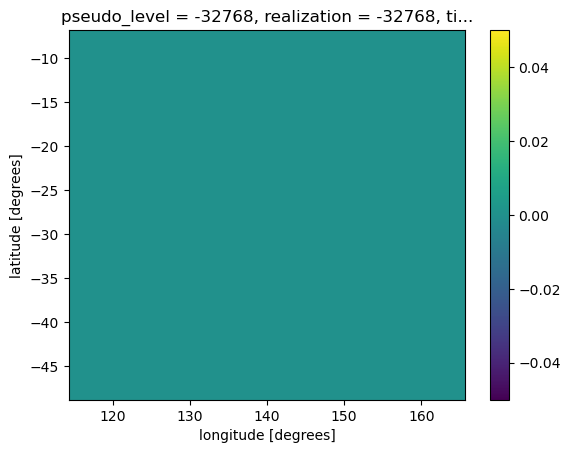

In [14]:
### Sanity check - identical over land
(um_lsm*(um_sst-updated_sst)).plot()

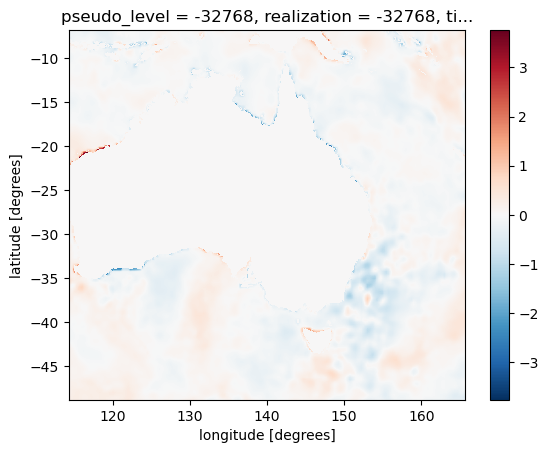

In [15]:
### Sanity check - different over ocean
((1-um_lsm)*(um_sst-updated_sst)).plot()

In [16]:
d=updated_sst.data.compute()

In [17]:
dump_mule = mule.load_umfile(dump_fn)

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.01/lib/python3.10/site-packages/mule/stashmaster.py:259: UserWarning: 
Unable to load STASHmaster from version string, path does not exist
Path: $UMDIR/vn12.2/ctldata/STASHmaster/STASHmaster_A
Please check that the value of mule.stashmaster.STASHMASTER_PATH_PATTERN is correct for your site/configuration
  warnings.warn(msg)


In [18]:
mf_out = dump_mule.copy()

In [19]:
array_provider = mule.ArrayDataProvider(d)

In [20]:
for f in dump_mule.fields:
    if f.lbuser4 != 24:
        mf_out.fields.append(f)
    else:
        new_field = f.copy()
        new_field.set_data_provider(array_provider)
        mf_out.fields.append(new_field)

In [21]:
mf_out.to_file(dump_out)

In [22]:
new_cubes = iris.load(dump_out)

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.01/lib/python3.10/site-packages/iris/fileformats/_ff.py:722: _WarnComboLoadingDefaulting: The stash code m01s00i060 is on a grid 22 which has not been explicitly handled by the fieldsfile loader. Assuming the data is on a P grid.
  warnings.warn(


In [23]:
for f in new_cubes:
    s=f.attributes['STASH']
    if s.model==1 and s.section==0 and s.item == 24:
        new_um_sst = xr.DataArray.from_iris(f)
        break

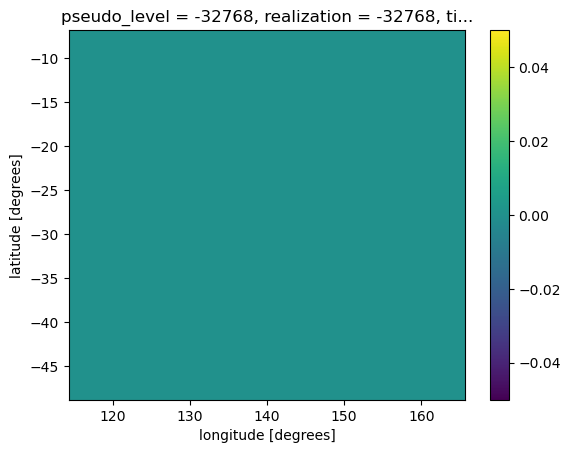

In [24]:
### Sanity check - identical over land
(um_lsm*(um_sst-new_um_sst)).plot()

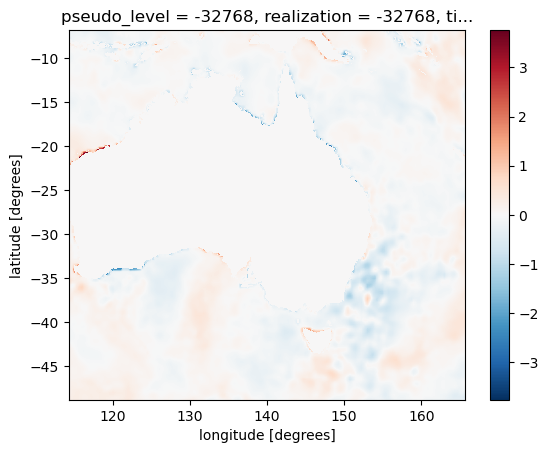

In [25]:
### Sanity check - different over ocean
((1-um_lsm)*(um_sst-new_um_sst)).plot()